In [25]:
from __future__ import division
import math
from math import atan2, pi, sqrt, cos, sin , acos
from cmath import exp
import numpy as np
from numpy import prod
import kwant
import random
from matplotlib import pyplot
from kwant.digest import uniform    # a (deterministic) pseudorandom number generator
from kwant.digest import gauss    # a (deterministic) pseudorandom number generator
from types import SimpleNamespace
from ipywidgets import interact

%run matplotlib_setup.ipy

In [ ]:
M = (0.036*m_e/(pi*((h/(2*pi))**2)))*abs(e)
n2D = 1e16 # [m-2] value of the average measured 2D electron density
Ef = 1000*n2D/M # measured Fermi energy (meV)

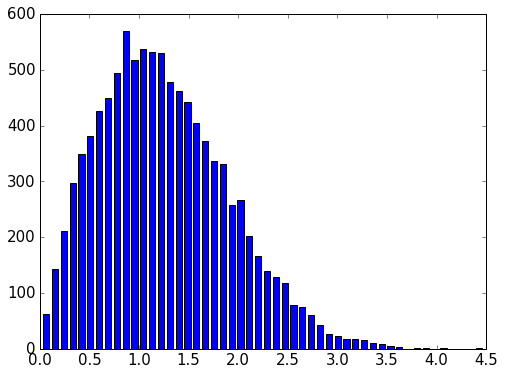

In [109]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import normal
from numpy.random import uniform

x = normal(0,1,10000)
y = normal(0,1,10000)
z = np.sqrt(x**2+y**2)
hist, bins = np.histogram(z, bins=50)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.show()

In [22]:
# Physical constants

h = 6.626069e-34    # Planck constant (Js)
e = 1.602e-19      # electron charge (C)
c = 299792458       # Light celerity (m/s)
kB = 1.3806503e-23  # Boltzmann constant (kg m2/Ks2)
m_e = 9.1e-31       # electron mass (kg)

#The 2DES is formed in a In_(x)Ga_(1-x)Al layer with x = 0.75
epsilon_r = 14 # [-] epsilon_r=x*epsilon_InAs(=14.6)+(1-x)*epsilon_GaAs(=13.1)-x*(1-x)
epsilon_0 = 8.854187e-12 # [Fm-1]

# Effective mass

m_eff = 0.036 # (-) = x*m_eff_InAs(=0.026) + (1-x)*m_eff_GaAs(=0.067) (m_eff_In0.53Ga0.47As measured as 0.043)

# Code written to simulate a disordered potential configuration
# the average dopant density in the dopant plane was 2.5e16 [m-2]

n2D = 1e16 # (m-2) value of the average measured 2D electron density

# General lattice parameters

a = 4 # Lattice parameter

lat = kwant.lattice.Monatomic([(a, 0), (0, a)],(0., 0.),norbs=1)

t = 1                     # hopping parameter at B = 0 
W = 300                   # width of the ring (nm)
L = 950                   # radius of the ring (nm)
l_lead = 750              # extra length for the leads - in order to avoid side effects (nm)
W_central = 500             # width of the central channel

# Orthogonal magnetic field
B = 0 # (T)
phi= B*(a**2)*(10**-18)/(h/e) #(-)

# In order to round angles in the structure, we define the radius Rc of small circle
# that are tangent to curves around the angular point defining the outer ring radius

Rc = 100                  # aforementionned radius

Rout = L+W/2              # outter ring radius
Rin = L-W/2               # inner ring radius

W_lead = W*(407/300)      # width of the leads

# Location of the first circles (lead tangent)

y0 = Rc+W_lead/2
x0 = sqrt((Rout+Rc)**2-(y0)**2)
alpha = acos(y0/(Rout+Rc))

# Location of the second circles (central channel tangent)

x1 = Rc+W_central/2
y1 = sqrt((Rin-Rc)**2-(x1)**2)
beta = acos(y1/(Rin-Rc))

# analytic definition of the nanodevice

def myshape(pos):
    x, y = pos
    return ((x**2 + y**2) > (Rin)**2 and (x**2 + y**2) < (Rout)**2)\
    or (abs(x)<W_central/2 and abs(y)<L) or ((abs(x)-L>0) and (abs(x)-(L+l_lead)<0) and (abs(y) < W_lead/2))\
    or ((x+x0)**2+(y-y0)**2 > Rc**2 and y>W_lead/2 and x > -x0 and x<-x0+Rc*sin(alpha))\
    or ((x+x0)**2+(y+y0)**2 > Rc**2 and y<-W_lead/2 and x > -x0 and x<-x0+Rc*sin(alpha))\
    or ((x-x0)**2+(y-y0)**2 > Rc**2 and y>W_lead/2 and x < x0 and x>x0-Rc*sin(alpha))\
    or ((x-x0)**2+(y+y0)**2 > Rc**2 and y<-W_lead/2 and x < x0 and x>x0-Rc*sin(alpha))\
    or ((x+x1)**2+(y-y1)**2 > Rc**2 and x<-W_central/2 and x>-x1-Rc*sin(beta) and y>y1 and (x**2 + y**2) < (Rin)**2)\
    or ((x-x1)**2+(y-y1)**2 > Rc**2 and x>W_central/2 and x<x1+Rc*sin(beta) and y>y1 and (x**2 + y**2) < (Rin)**2)\
    or ((x+x1)**2+(y+y1)**2 > Rc**2 and x<-W_central/2 and x>-x1-Rc*sin(beta) and y<-y1 and (x**2 + y**2) < (Rin)**2)\
    or ((x-x1)**2+(y+y1)**2 > Rc**2 and x>W_central/2 and x<x1+Rc*sin(beta) and y<-y1 and (x**2 + y**2) < (Rin)**2)



# definition of the onsite energy of the tight-binding model

# disorder flag - 0 : no disorder / 1 : disorder
disorder_flag = 1 
disorder = np.loadtxt('disorder_a=4nm.dat').T # the .dat file is generated by the notebook 'disorder.ipynb'

def onsite(site,Vtip,xtip,ytip,Rtip):
    x, y = site.pos
    M = (0.036*m_e/(pi*((h/(2*pi))**2)))*abs(e)
    n2D = 1e16 # [m-2] value of the average measured 2D electron density
    Ef = 1000*n2D/M # measured Fermi energy (meV)
    if(disorder_flag):
        return (1000*disorder[int((Rout-y)/a),int((L+l_lead-x)/a)]/Ef)*energy + 4 * t + Vtip /(1+((x-xtip)**2+(y-ytip)**2)/Rtip**2)
    else:
        return 4 * t + Vtip /(1+((x-xtip)**2+(y-ytip)**2)/Rtip**2)

# definion of the hopping parameter
def hopping(site_i, site_j):
    xi, yi = site_i.pos
    xj, yj = site_j.pos
    return -t*exp(-0.5j * phi * (xi - xj) * (yi + yj))

# build the 2DES (syst)
syst = kwant.Builder()
syst[lat.shape(myshape,(L,0))] = onsite
syst[lat.neighbors()] = hopping

# build the leads and attach them

def lead_shape(pos):
    x,y = pos
    return abs(y) < (W*(407/300)/2)

sym=kwant.TranslationalSymmetry(lat.vec((-a,0)))
lead =kwant.Builder(sym)
lead[lat.shape(lead_shape,(0,0))]= onsite
lead[lat.neighbors()]=hopping
syst.attach_lead(lead)
syst.attach_lead(lead.reversed())

syst = syst.finalized()

In [17]:
kwant.plot(syst);

NameError: name 'mplot3d' is not defined

In [6]:
# Magnetic field
B = 0 # (T)
phi= B*(a**2)*(10**-18)/(h/e) #(-)

# energy (E/t) at which the conductance is computed
density = 1*10**16 # typical density in InGaAs 2 DES
energy = 2*pi*density*(a**2)*(10**-18)

# Tip potential parameters
xtip = 0
ytip = 20
Rtip = 150       # Full width at half maximum (FWHM) of the potential distribution
Vtip = 0.9*energy # The sign of Vtip define the electrostatic coupling ! + : depletion ; - : accumulation

-1520.0 10.2469422015
-1459.2 12.3920648494
-1398.4 12.1219187184
-1337.6 11.9672129159
-1276.8 12.5592599033
-1216.0 13.0699576322
-1155.2 13.5905415272
-1094.4 14.9650063634
-1033.6 14.6995281902
-972.8 18.7831705279
-912.0 18.2823033801
-851.2 21.1625709575
-790.4 20.7644218427
-729.6 20.5180688785
-668.8 19.9003961007
-608.0 17.5260526623
-547.2 18.4454031014
-486.4 16.5752094584
-425.6 18.0300821745
-364.8 18.3454588519
-304.0 16.2679728698
-243.2 15.4638506017
-182.4 13.6413112664
-121.6 11.1604913183
-60.8 9.25417841921
0.0 7.61190738013
60.8 9.43663973706
121.6 11.0680068381
182.4 12.9593880176
243.2 15.8966901236
304.0 15.7673109428
364.8 16.9327360028
425.6 17.0510170041
486.4 16.8666045575
547.2 17.1506858862
608.0 18.1635501894
668.8 20.0584080395
729.6 20.179331404
790.4 20.4683162183
851.2 21.2222820434
912.0 19.1210361423
972.8 19.0057752362
1033.6 16.0407154463
1094.4 14.7939143196
1155.2 13.9349019136
1216.0 12.9628468367
1276.8 13.5896732116
1337.6 12.5877087419
1398.

Text(0.5,0,'xtip')

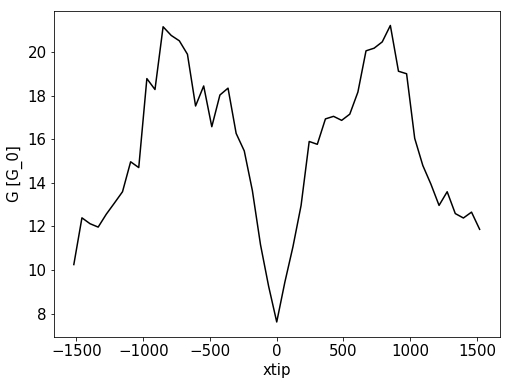

In [23]:
#######################################################################################################
#   This part of the code is dedicated to simple sweep                                                #
#######################################################################################################

#file=open('sweep.dat',"w")

G = []

xtips=np.linspace(-1.6*L,1.6*L,num=51)

for i,xtip in enumerate(xtips):
    #params = SimpleNamespace(phi=phi, Vtip=Vtip, xtip=xtip, ytip=ytip, Rtip=Rtip)
    smat = kwant.smatrix(syst, energy=energy, params = dict(Vtip = Vtip,xtip=xtip,ytip=ytip,Rtip=Rtip))
    G.append(smat.transmission(1, 0))
    print (xtip,G[i])
    #file.write("%.7f %.7f \n" % (xtip,G[i]))  #Inscrire les valeurs dans un fichier
    #file.flush()
    
plt.plot(xtips, G);
plt.ylabel("G [G_0]")
plt.xlabel("xtip")

In [ ]:
#######################################################################################################
#   This part of the code is dedicated to the parameters that we will vary to realise 2D mappings of  #
#   the conductance G : SGM maps (xtip vs ytip), transport through potential barriers for different   #
#   tip potential values (b1 vs Vtip), Energy vs Vtip ...                                             #
#######################################################################################################

Npts_xtip=301
Npts_ytip=301

xtips = np.linspace(-1.3*L, 0, Npts_xtip)

energies = np.linspace(-1.3*L, 1.3*L, Npts_ytip)

file=open("ABS_%s.dat"% os.environ["SLURM_ARRAY_TASK_ID"],"w")

G = np.zeros((Npts_xtip,Npts_ytip))

i = int(os.environ["SLURM_ARRAY_TASK_ID"])

ytip = ytips[i]
for j,xtip in enumerate(xtips):
    params = SimpleNamespace(phi=phi, Vtip=Vtip, xtip=xtip,ytip=ytip, Rtip=Rtip)
    smat = kwant.smatrix(syst, energy=energy, args=[params])
    G[i,j]=smat.transmission(1, 0)
    print(ytip,xtip,G[i,j])
    file.write("%.7f %.7f %.7f \n" % (ytip,xtip,G[i,j]))  #Inscrire les valeurs dans un fichier
    file.flush()

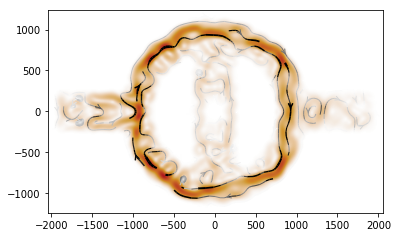

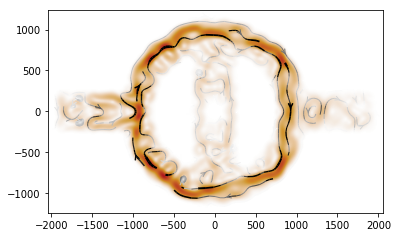

In [3]:
# energy (E/t) at which the conductance is computed
density = 1*10**16 # typical density in InGaAs 2 DES
energy = 2*pi*density*(a**2)*(10**-18)

# Tip potential parameters
xtip = 0
ytip = 0
Rtip = 150       # Full width at half maximum (FWHM) of the potential distribution
alpha = 0
Vtip = 2*energy # The sign of Vtip define the electrostatic coupling ! + : depletion ; - : accumulation

psi = kwant.wave_function(syst, energy = energy, params = dict(Vtip = Vtip,xtip=xtip,ytip=ytip,Rtip=Rtip))(0)[0]
#psi = wfs(0)[0]  # all scattering wave functions from lead 0
J=kwant.operator.Current(syst)
current = J(psi)

#kwant.plotter.current(syst, current, relwidth=0.05)
kwant.plotter.current(syst, current, relwidth=0.05, colorbar=True)

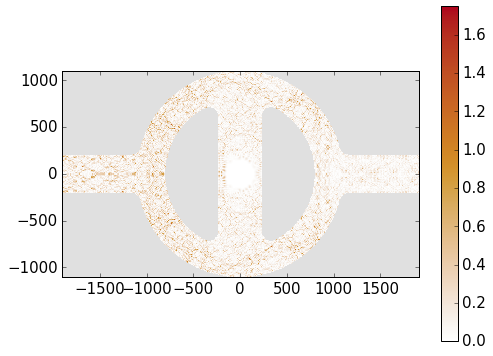

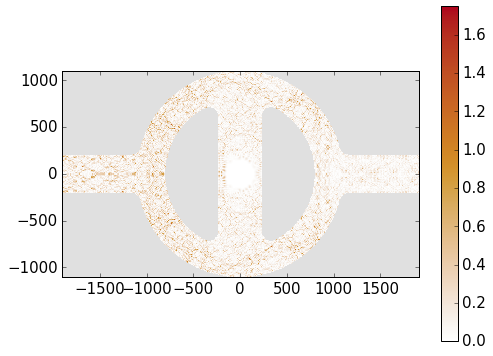

In [97]:
# energy (E/t) at which the conductance is computed
density = 1*10**16 # typical density in InGaAs 2 DES
energy = 2*pi*density*(a**2)*(10**-18)

# Tip potential parameters
xtip = 0
ytip = 0
Rtip = 150       # Full width at half maximum (FWHM) of the potential distribution
alpha = 0
Vtip = 2*energy # The sign of Vtip define the electrostatic coupling ! + : depletion ; - : accumulation

ldos = kwant.ldos(syst, energy=energy, params = dict(Vtip = Vtip,xtip=xtip,ytip=ytip,Rtip=Rtip))
#wfs = kwant.wave_function(syst, energy=energy, args=[params])
#psi = wfs(0)[0]  # all scattering wave functions from lead 0
    #scattering_wf_R = wfs(1)  # all scattering wave functions from lead 1
    #kwant.plotter.map(syst, np.sum(abs(scattering_wf_L)**2, axis=0),vmax=1)
kwant.plotter.map(syst, ldos,vmin=0,vmax=0.42)